# Mission Arthur RB


In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import networkx as nx
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_theme()

In [173]:
df_rb_beers     = pd.read_csv('../data/rate_beer/beers.csv')
df_rb_breweries = pd.read_csv('../data/rate_beer/breweries.csv')
df_rb_users     = pd.read_csv('../data/rate_beer/users.csv')
df_rb_ratings   = pd.read_csv('../data/rate_beer/ratings.csv')

df_ba_beers     = pd.read_csv('../data/beer_advocate/beers.csv')
df_ba_breweries = pd.read_csv('../data/beer_advocate/breweries.csv')
df_ba_users     = pd.read_csv('../data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('../data/beer_advocate/ratings.csv')

In [174]:
df_rb_users['user_country_code'].unique()

array(['USA', 'AUS', 'THA', nan, 'CHE', 'CAN', 'NLD', 'MNE', 'NOR', 'BEL',
       'POL', 'FIN', 'DNK', 'SRB', 'FRA', 'GBR', 'BOL', 'PRI', 'EGY',
       'LTU', 'NZL', 'DEU', 'BHS', 'LUX', 'ITA', 'IND', 'ARG', 'IRL',
       'SWE', 'RUS', 'PRT', 'CAF', 'BGR', 'ISL', 'MLT', 'TWN', 'ZAF',
       'HRV', 'VEN', 'COL', 'JPN', 'CRI', 'ESP', 'PHL', 'ZWE', 'AUT',
       'SDN', 'SGP', 'BRA', 'MDA', 'PAK', 'CYP', 'MEX', 'CHL', 'BIH',
       'HKG', 'VIR', 'SLV', 'JAM', 'TZA', 'NAM', 'SVN', 'TUR', 'ROU',
       'IMN', 'CHN', 'JEY', 'AND', 'ISR', 'PRK', 'GRC', 'LAO', 'PAN',
       'VUT', 'FSM', 'BMU', 'PER', 'LVA', 'DOM', 'ALB', 'HUN', 'EST',
       'VAT', 'UKR', 'MUS', 'FRO', 'GHA', 'GUM', 'ZMB', 'AZE', 'NGA',
       'VGB', 'TLS', 'BWA', 'MHL', 'KEN', 'UZB', 'LIE', 'TGO', 'ECU',
       'MKD', 'URY', 'CYM', 'IDN', 'HMD', 'VNM', 'MCO', 'MOZ', 'TUN',
       'GTM', 'SYR', 'TTO', 'KHM', 'MYS', 'ASM', 'PNG', 'NIC', 'BDI',
       'AFG', 'HTI', 'LBN', 'BGD', 'UGA', 'BFA', 'NPL', 'CUB', 'BLR',
       'PSE', '

In [175]:
df_rb_ratings['day']     = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('D')
df_rb_ratings['week']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_rb_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_rb_ratings['quarter'] = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Q')
df_rb_ratings['year']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Y')

#df_rb_ratings['day']     = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('D')
#df_rb_ratings['week']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('W').dt.start_time
#df_rb_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('M').dt.start_time
#df_rb_ratings['quarter'] = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Q')
#df_rb_ratings['year']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Y')

# Pre-processing 

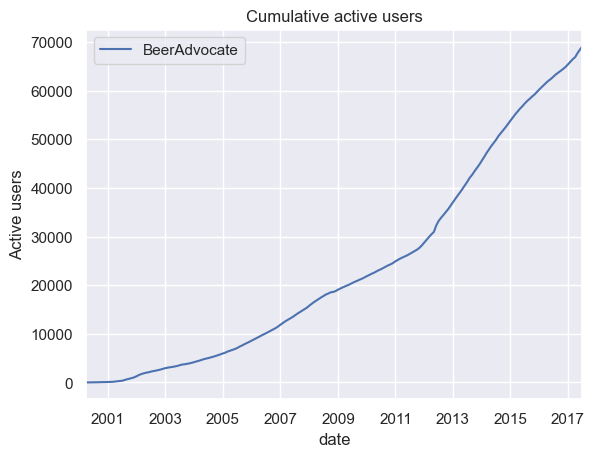

In [176]:
plt.title('Cumulative active users')
plt.xlabel('Month')
plt.ylabel('Active users')
pd.to_datetime(df_rb_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='BeerAdvocate')
#pd.to_datetime(df_rb_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='RateBeer')
plt.legend()

In [177]:
def compute_cumulative_ratings_count(dataframe: pd.DataFrame):
    dataframe = dataframe.sort_values(['date'])
    dataframe['_count'] = 1
    dataframe['cumulative_ratings_count'] = dataframe['_count'].cumsum()
    dataframe = dataframe.drop(columns=['_count'])
    return dataframe

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

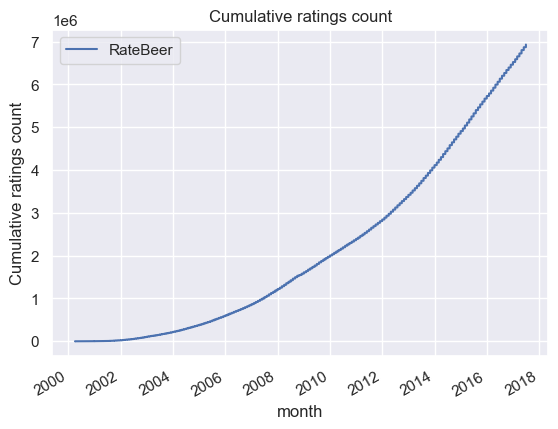

In [178]:
fig, ax = plt.subplots()
plt.title('Cumulative ratings count')
plt.xlabel('Month')
plt.ylabel('Cumulative ratings count')
#compute_cumulative_ratings_count(df_ba_ratings).plot(x='month', y='cumulative_ratings_count', label='BeerAdvocate', ax=ax)
compute_cumulative_ratings_count(df_rb_ratings).plot(x='month', y='cumulative_ratings_count', label='RateBeer', ax=ax)

**Internet majority adoption is around 2004 (50% of population using it regularly) + lot of noise before 2004 so the analysis will focus on the time period after January 2004**

In [179]:
def remove_before_month(dataframe: pd.DataFrame, month: str = '2004-01') -> pd.DataFrame:
    dataframe = dataframe.sort_values(['user_id', 'date'])
    dataframe = dataframe.merge(
        (dataframe.groupby('user_id')['month'].first() >= month).reset_index().rename(columns={'month': 'is_first_rating_after_month'}),
        on='user_id'
    )
    dataframe = dataframe[dataframe['is_first_rating_after_month']]
    dataframe = dataframe.drop(columns=['is_first_rating_after_month'])
    return dataframe

In [180]:
#df_ba_ratings = remove_before_month(df_ba_ratings, '2004-01')
df_rb_ratings = remove_before_month(df_rb_ratings, '2004-01')

# 1. Inflations

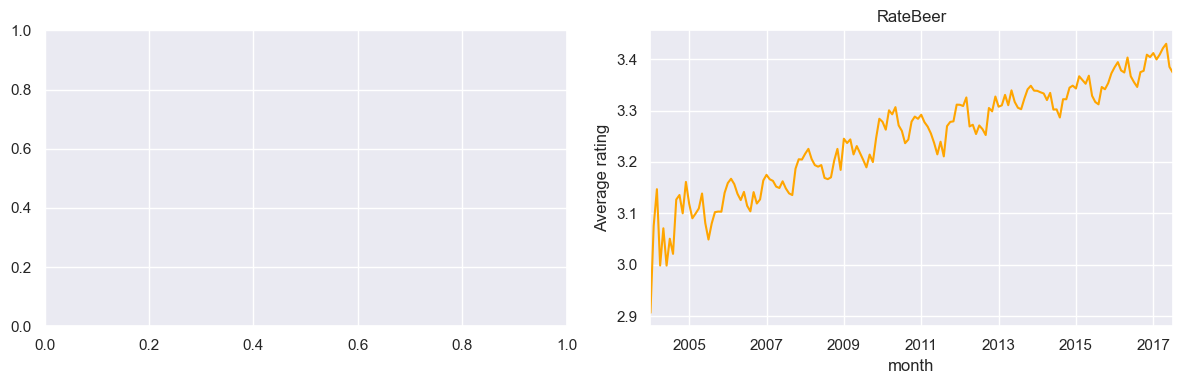

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#axs[0].set_title('BeerAdvocate')
#axs[0].set_xlabel('Month')
#axs[0].set_ylabel('Average rating')
#df_ba_ratings.groupby('month')['rating'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

In [182]:
def create_time_serie(dataframe: pd.DataFrame, time_column: str, value_column: str, frequency: str = 'W') -> pd.DataFrame:
    full_range = pd.DataFrame(index=pd.date_range(start=dataframe[time_column].min(), end=dataframe[time_column].max(), freq=frequency).to_period('W').start_time)
    partial_time_serie = dataframe.groupby(time_column)[value_column].mean()
    time_serie = pd.merge(full_range, partial_time_serie, left_index=True, right_index=True, how='left').fillna(0)
    return time_serie

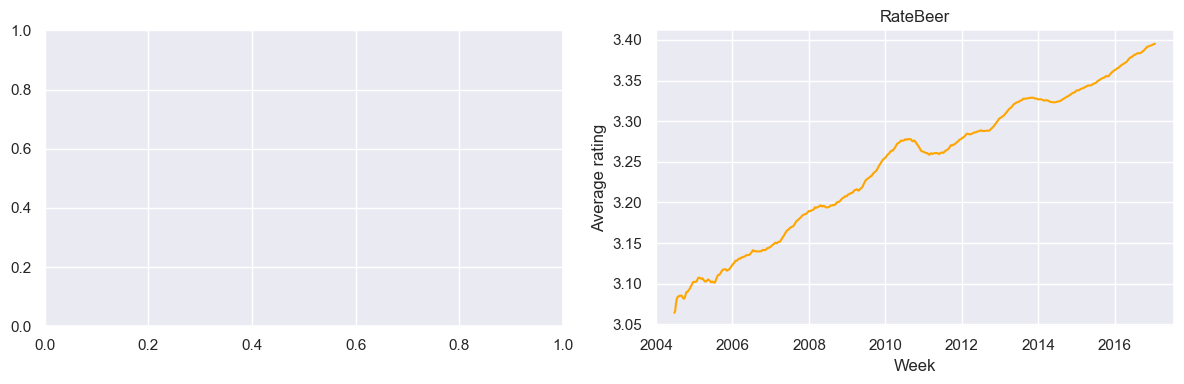

In [183]:
#df_ba_decomposition = seasonal_decompose(create_time_serie(df_ba_ratings, 'week', 'rating'), model='additive', period=52)
df_rb_decomposition = seasonal_decompose(create_time_serie(df_rb_ratings, 'week', 'rating'), model='additive', period=52)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating general trend')

#axs[0].set_title('BeerAdvocate')
#axs[0].set_xlabel('Week')
#axs[0].set_ylabel('Average rating')
#df_ba_decomposition.trend.plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_decomposition.trend.plot(ax=axs[1], color='orange')

plt.tight_layout()

In [184]:
def correct_inflation(dataframe: pd.DataFrame, trend: pd.Series) -> pd.DataFrame:
    trend = trend.dropna()
    reference_mean = trend.iloc[0]
    IPC = trend / reference_mean
    
    dataframe = dataframe.loc[dataframe['week'] >= trend.index[0]]

    beta_0 = IPC.iloc[0]
    beta_1 = (IPC.iloc[-1] - IPC.iloc[0]) / len(IPC)

    for week in pd.date_range(start=IPC.index.max(), end=dataframe['week'].max(), freq='W').to_period('W').start_time:
        diff = (week + pd.Timedelta(weeks=1) - IPC.index.min()) / pd.Timedelta(weeks=1)
        IPC.loc[week + pd.Timedelta(weeks=1)] = beta_0 + beta_1 * diff
    
    dataframe.loc[:, 'rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values
    return dataframe

/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_53602/2732673448.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, 'rating_corrected'] = dataframe['rating'] / IPC.reindex(dataframe['week']).values


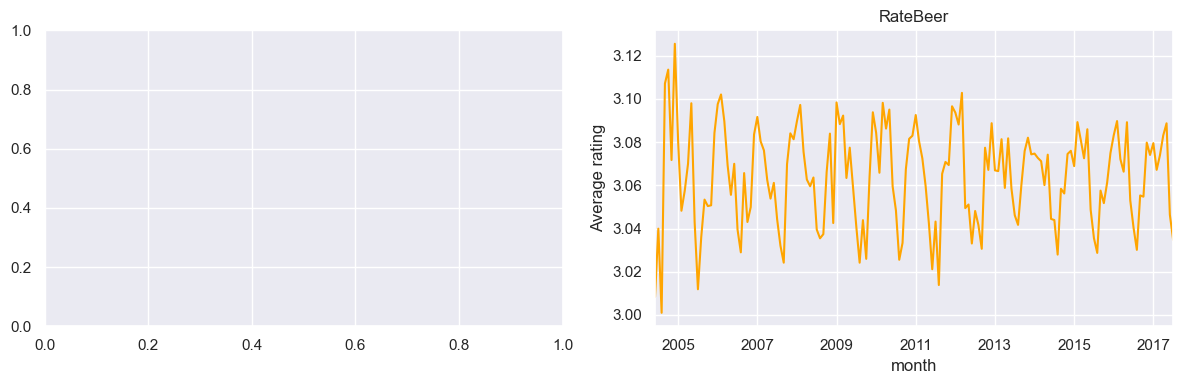

In [185]:
#df_ba_ratings = correct_inflation(df_ba_ratings, df_ba_decomposition.trend)
df_rb_ratings = correct_inflation(df_rb_ratings, df_rb_decomposition.trend)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.title('Rating average over time corrected for inflation')

#axs[0].set_title('BeerAdvocate')
#axs[0].set_xlabel('Week')
#axs[0].set_ylabel('Average rating')
#df_ba_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Average rating')
df_rb_ratings.groupby('month')['rating_corrected'].mean().plot(ax=axs[1], color='orange')

plt.tight_layout()

# 2. Rating scales

In [186]:
def compute_scale_distribution(dataframe: pd.DataFrame) -> pd.DataFrame:
    new_dataframe = dataframe.groupby('user_id')['rating_corrected'].quantile([0.01, 0.025, 0.05, 0.1, 0.9, 0.95, 0.975, 0.99]).unstack()
    new_dataframe = new_dataframe.merge(dataframe.groupby('user_id')['rating_corrected'].count(), left_index=True, right_index=True)
    new_dataframe = new_dataframe.rename(columns={'rating_corrected': 'count'}).dropna()
    new_dataframe['difference'] = new_dataframe[0.975] - new_dataframe[0.025]
    new_dataframe.columns = [str(c) for c in new_dataframe.columns]
    return new_dataframe

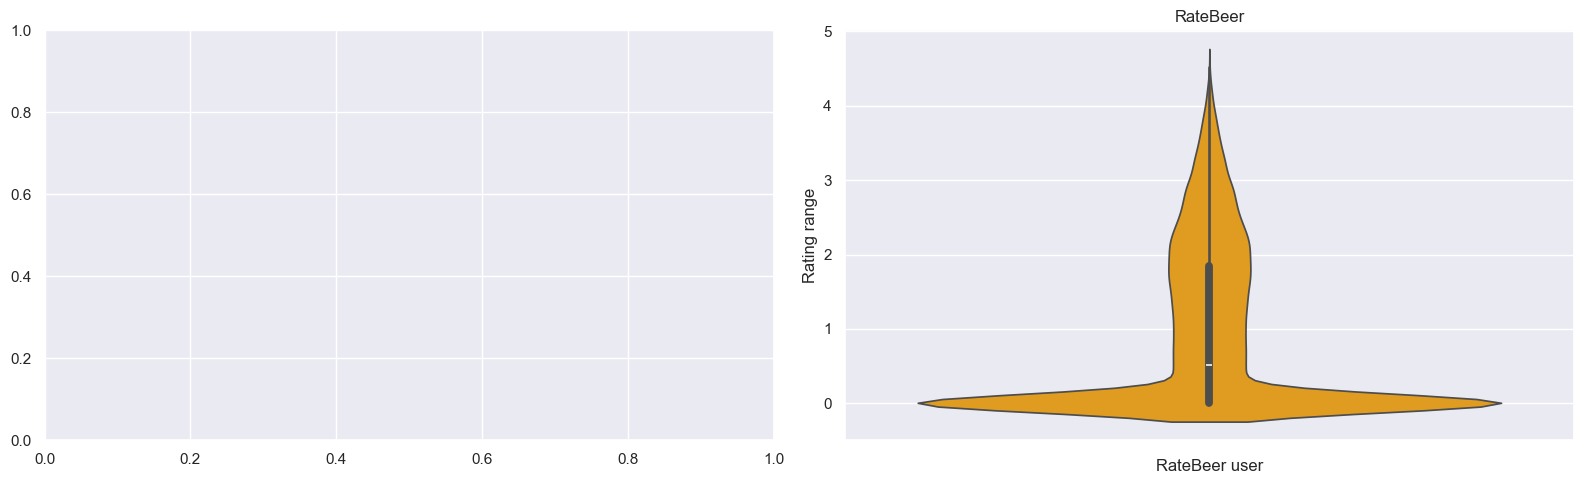

In [187]:
#df_ba_scales = compute_scale_distribution(df_ba_ratings)
df_rb_scales = compute_scale_distribution(df_rb_ratings)

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
plt.title('Distribution of rating range')

#axs[0].set_title('BeerAdvocate')
#axs[0].set_xlabel('BeerAdocate user')
#axs[0].set_ylabel('Rating range')
#sns.violinplot(df_ba_scales['difference'], ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales['difference'], ax=axs[1], color='orange')

plt.tight_layout()

In [188]:
for threshold in [10, 50, 100, 500, 1000]:
    #df_ba_scales[f'at_least_{threshold}'] = (df_ba_scales['count'] > threshold).astype(int) * threshold
    df_rb_scales[f'at_least_{threshold}'] = (df_rb_scales['count'] > threshold).astype(int) * threshold

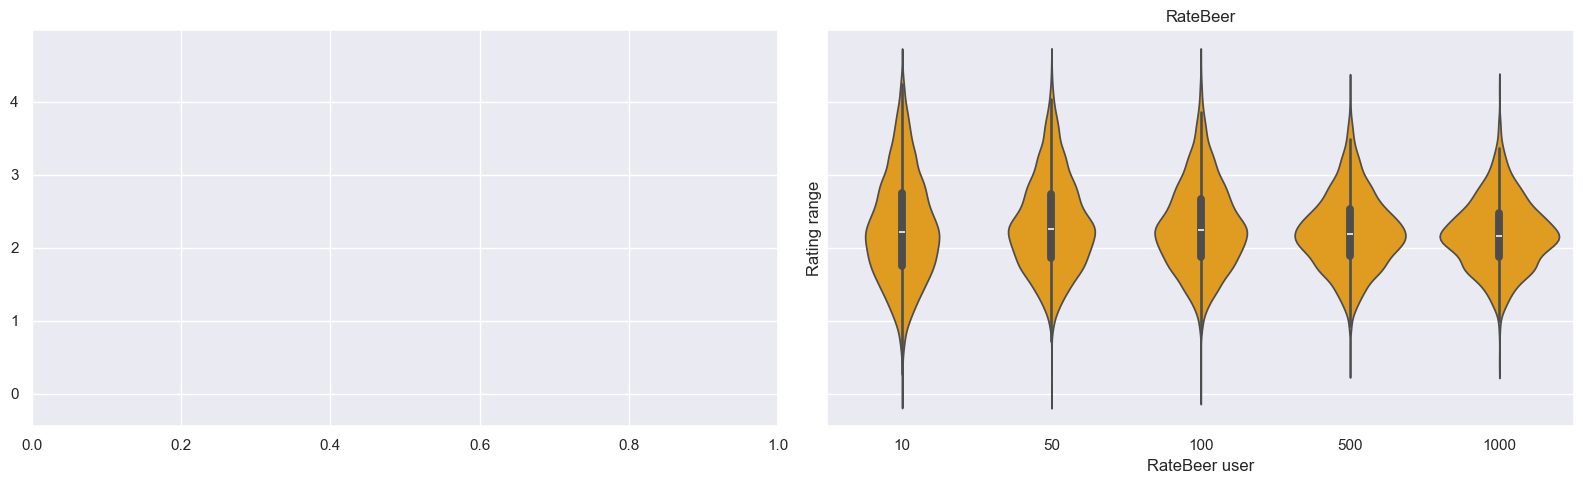

In [189]:
#df_ba_scales = pd.wide_to_long(df_ba_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])
df_rb_scales = pd.wide_to_long(df_rb_scales.reset_index(), stubnames='at_least_', i='user_id', j='threshold').reset_index().drop(columns=['at_least_'])

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
plt.title('Distribution of rating ranges')

#axs[0].set_title('BeerAdvocate')
#axs[0].set_xlabel('BeerAdocate user')
#axs[0].set_ylabel('Rating range')
#sns.violinplot(data=df_ba_scales[df_ba_scales['count'] > df_ba_scales['threshold']], x='threshold', y='difference', ax=axs[0])

axs[1].set_title('RateBeer')
axs[1].set_xlabel('RateBeer user')
axs[1].set_ylabel('Rating range')
sns.violinplot(df_rb_scales[df_rb_scales['count'] > df_rb_scales['threshold']], x='threshold', y='difference', ax=axs[1], color='orange')

plt.tight_layout()

# Analysis of reviews

In [190]:
df_rb_nlp  = pd.read_csv('../data/rate_beer/nlp_predictions_rb_full.csv', index_col=0)
df_regions = pd.read_csv('../data/regions.csv')

In [191]:
df_rb_nlp.columns = [column for column in df_rb_nlp.columns[:-1]] + ['nlp_weighted_rating']
df_rb_nlp.head()

,1,2,3,4,5,nlp_weighted_rating
3038913,0.000672,0.000594,0.003023,0.070353,0.925357,4.929344
6294302,0.302793,0.398735,0.196482,0.066351,0.035639,1.881615
1553853,0.024299,0.125125,0.405762,0.361356,0.083458,3.264761
5729394,0.001291,0.001198,0.003388,0.085703,0.908420,4.913790
3775132,0.072753,0.511240,0.389289,0.024641,0.002077,2.325225


In [192]:
df_rb_users.head()

,user_id,user_ratings_count,user_name,user_created_date,user_country,user_region,user_country_code
0,2,52,wade,955533600.0,United States,Georgia,USA
1,3,219,billb,955533600.0,United States,Georgia,USA
2,7,42,young,955533600.0,United States,Georgia,USA
3,10,5,Mark99,955533600.0,United States,Georgia,USA
4,15,1,lazarus99,955533600.0,United States,Georgia,USA


In [193]:
df_rb_ratings   = df_rb_ratings.loc[~(df_rb_ratings['beer_global_style'] == 'Low Alcohol Beer')]

df_rb_users     = df_rb_users.merge(df_regions, left_on='user_country_code', right_on='ISO3', how='left').drop(columns=['ISO3'])
df_rb_breweries = df_rb_breweries.merge(df_regions, left_on='brewery_country_code', right_on='ISO3', how='left').drop(columns=['ISO3'])

df_rb_users     = df_rb_users.rename(columns={'region': 'user_country_region'})
df_rb_breweries = df_rb_breweries.rename(columns={'region': 'brewery_country_region'})

df_rb_ratings = df_rb_ratings.merge(df_rb_nlp, left_index=True, right_index=True)
df_rb_ratings = df_rb_ratings.merge(df_rb_users, on='user_id')
df_rb_ratings = df_rb_ratings.merge(df_rb_breweries, on='brewery_id')

In [194]:
df_rb_ratings['rating_relative_error'] = (df_rb_ratings['rating_corrected'] - df_rb_ratings['nlp_weighted_rating']) / df_rb_ratings['nlp_weighted_rating']
df_rb_ratings['rating_absolute_error'] =  df_rb_ratings['rating_corrected'] - df_rb_ratings['nlp_weighted_rating']

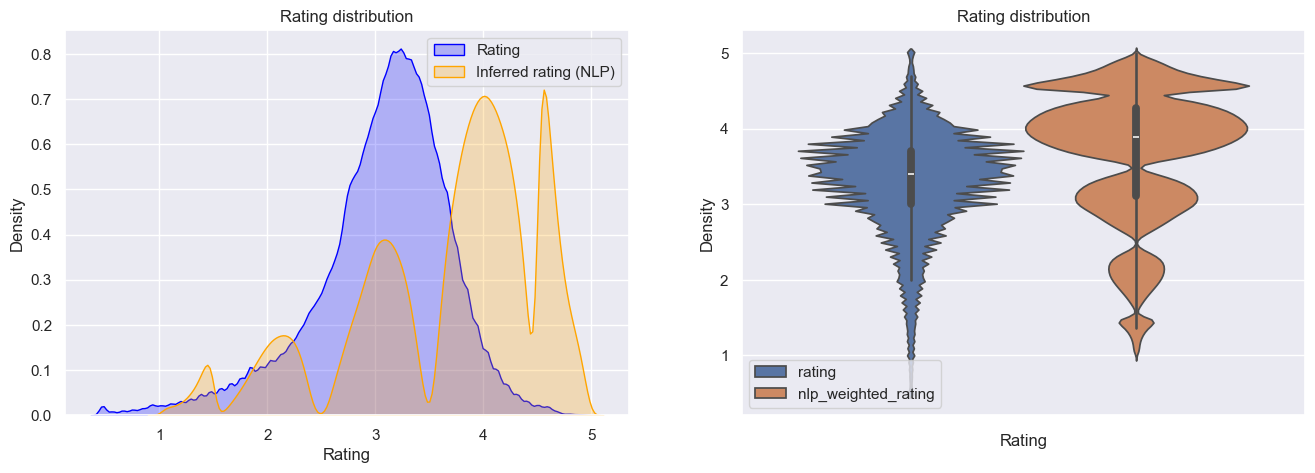

In [195]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
plt.title('Distribution of rating ranges')

axs[0].set_title('Rating distribution')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Density')
sns.kdeplot(df_rb_ratings['rating_corrected'], label='Rating', fill=True, color='blue', ax=axs[0])
sns.kdeplot(df_rb_ratings['nlp_weighted_rating'], label='Inferred rating (NLP)', fill=True, color='orange', ax=axs[0])
axs[0].legend()

axs[1].set_title('Rating distribution')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Density')
sns.violinplot(df_rb_ratings.melt(id_vars=['user_id', 'beer_id'], value_vars=['rating', 'nlp_weighted_rating']), hue='variable', y='value', ax=axs[1])
axs[1].legend()

plt.show()

## User country region

In [196]:
NLP_MIN_USERS_PER_REGION = 100

df_rb_nlp_regions = df_rb_ratings.dropna(subset=['user_country_region', 'brewery_country_region'])

users_per_region = df_rb_nlp_regions['user_country_region'].value_counts()
users_per_region = users_per_region[users_per_region >= NLP_MIN_USERS_PER_REGION]
df_rb_nlp_regions = df_rb_nlp_regions[df_rb_nlp_regions['user_country_region'].isin(users_per_region.index)]

In [197]:
NLP_ERROR_COLUMN = 'rating_relative_error'
anova_result = f_oneway(*[group[NLP_ERROR_COLUMN].values for _, group in df_rb_nlp_regions.groupby('user_country_region')])
print(anova_result)

F_onewayResult(statistic=1844.0963488723667, pvalue=0.0)


**The result of one-way ANOVA indicates that the null hypothesis should be rejected at the threshold 0.05. Thus we reject the null hypothesis which states that the groups have the same mean** 

In [198]:
def tukey_test(dataframe: pd.DataFrame, group_column: str, value_column: str, alpha: float = 0.05) -> pd.DataFrame:
    tukey = pairwise_tukeyhsd(endog=dataframe[value_column], groups=dataframe[group_column], alpha=alpha)
    raw_results = np.array(tukey.summary().data)

    df_tukey = pd.DataFrame(raw_results[1:], columns=[str(c) for c in raw_results[0]])
    df_tukey = df_tukey[df_tukey['reject'] == 'True']
    df_tukey = df_tukey.drop(columns=['reject'])

    df_tukey['weight'] = 1 - df_tukey['p-adj'].astype(float)
    df_tukey['difference'] = df_tukey['meandiff'].astype(float)
    df_tukey['absolute_difference'] = df_tukey['difference'].abs()
    df_tukey = df_tukey.drop(columns=['p-adj', 'meandiff'])

    return df_tukey

In [199]:
df_rb_nlp_regions['user_country_region'].unique()

array(['Western Europe', 'North America', 'Northern Europe', 'East Asia',
       'Pacific', 'South West Asia', 'South East Europe',
       'South West Europe', 'Central Europe', 'Eastern Europe',
       'Central America', 'Southern Europe', 'South America',
       'South East Asia', 'Southern Africa', 'Central Africa',
       'Northern Asia', 'West Indies', 'South Asia',
       'Southern Indian Ocean'], dtype=object)

In [200]:
df_rb_nlp_tuckey = tukey_test(df_rb_nlp_regions, 'user_country_region', NLP_ERROR_COLUMN)

G = nx.DiGraph()

for i, row in df_rb_nlp_tuckey.iterrows():
    if row['absolute_difference'] < 0.01: continue

    G.add_node(row['group1'], mean_error=df_rb_nlp_regions[df_rb_nlp_regions['user_country_region'] == row['group1']][NLP_ERROR_COLUMN].mean())
    G.add_node(row['group2'], mean_error=df_rb_nlp_regions[df_rb_nlp_regions['user_country_region'] == row['group2']][NLP_ERROR_COLUMN].mean())

    if row['difference'] < 0:
        G.add_edge(row['group2'], row['group1'], weight=row['absolute_difference'], difference=row['absolute_difference'])
    else:
        G.add_edge(row['group1'], row['group2'], weight=row['absolute_difference'], difference=row['absolute_difference'])

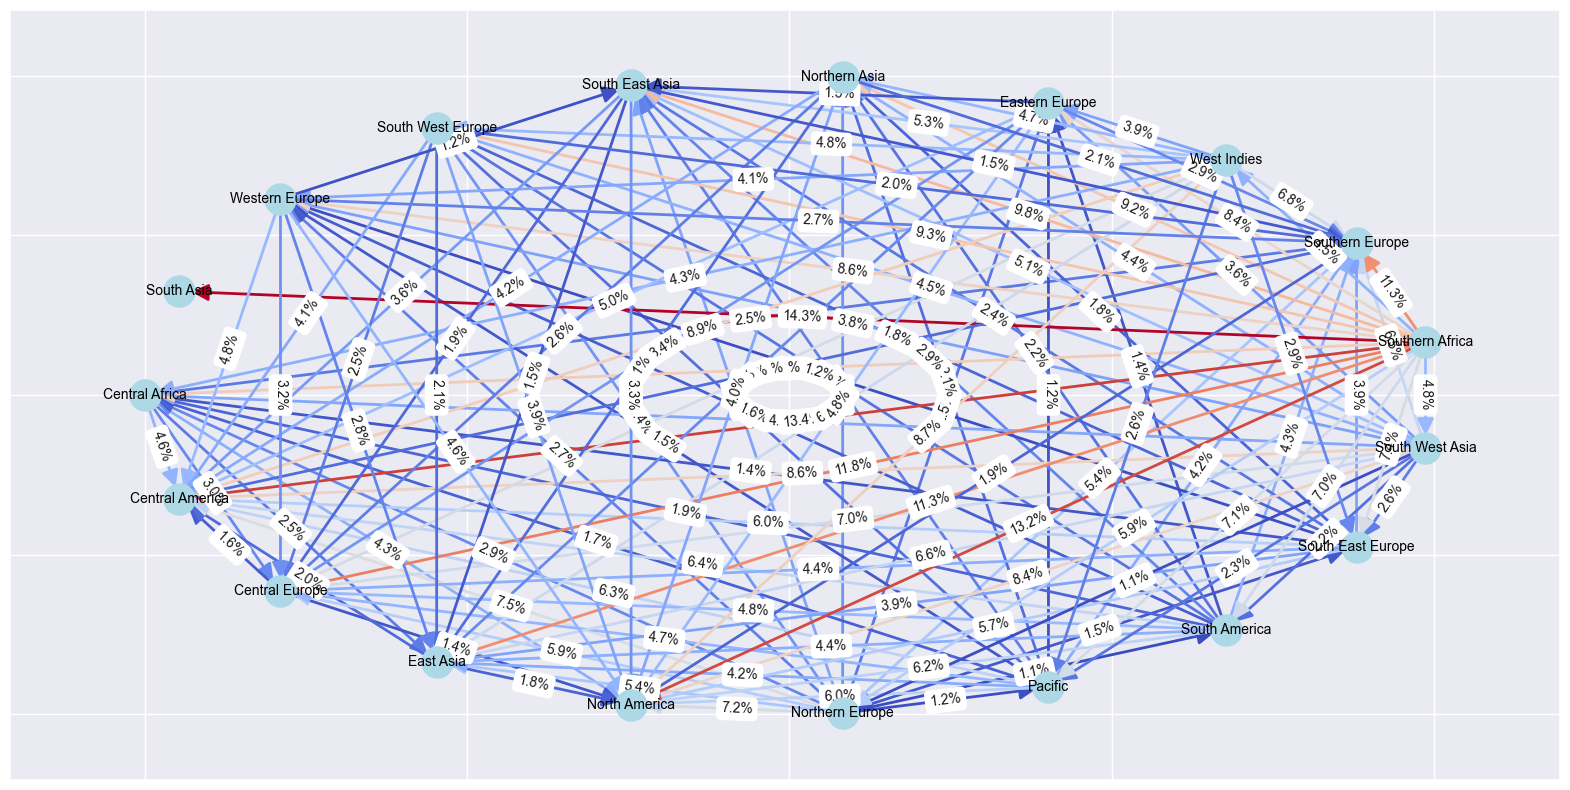

In [201]:
plt.figure(figsize=(20, 10))
pos = nx.shell_layout(G)

edges = G.edges(data=True)
edge_colors = [d['difference'] for (_, _, d) in edges]
edge_widths = [2 for (_, _, d) in edges]

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.coolwarm, arrowsize=25)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', )
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['difference']*100:.1f}%" for (u, v, d) in edges})

plt.show()

In [202]:
nx.is_directed_acyclic_graph(G)

True

**Since the graph is a DAG, we can perform a topological sort on it**

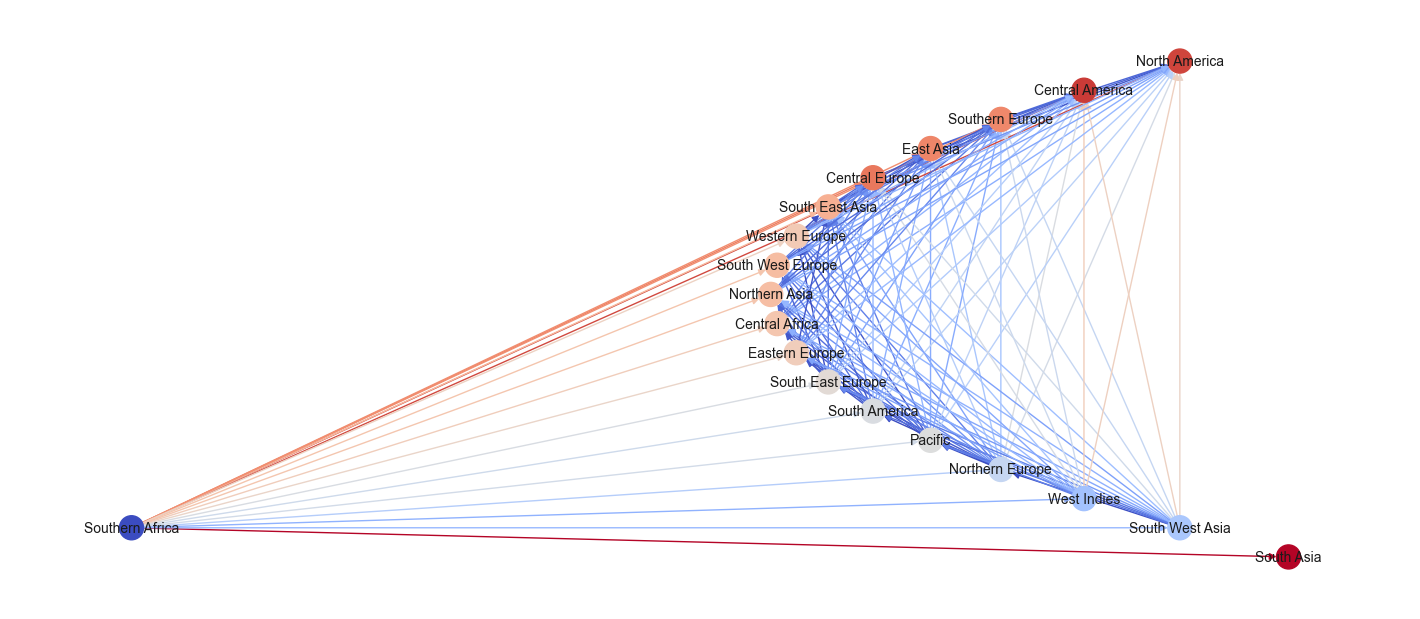

In [203]:
topological_order = list(nx.topological_sort(G))

in_degree_zero = [node for node, degree in G.in_degree() if degree == 0]    
pos = {}

# Place nodes with in-degree of 0 on the left vertical line
for i, node in enumerate(in_degree_zero):
    pos[node] = (0, 2 * i)

# Place remaining nodes on the horizontal line in the middle
remaining_nodes = [node for node in topological_order if node not in in_degree_zero]
for i, node in enumerate(remaining_nodes):
    pos[node] = (1 + 0.01 * (abs(len(remaining_nodes) // 2 - i)) ** 2, -len(in_degree_zero) // 2 + 1 * i)


node_colors = [G.nodes[node]['mean_error'] for node in G.nodes]

plt.figure(figsize=(14, 6))
nx.draw(
    G, 
    pos,
    with_labels=True, 
    arrows=True, 
    node_size=300, 
    font_size=10,
    arrowsize=10,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    edge_color=[d['difference'] for (_, _, d) in G.edges(data=True)],
    edge_cmap=plt.cm.coolwarm,
)
plt.show()

In [204]:
def keep_first_edges_dag(graph: nx.DiGraph) -> nx.DiGraph:
    visited = set()
    new_graph = nx.DiGraph()
    
    for node in nx.topological_sort(graph):
        for neighbor in graph.successors(node):
            if neighbor not in visited:
                new_graph.add_node(node, mean_error=graph.nodes[node]['mean_error'])
                new_graph.add_node(neighbor, mean_error=graph.nodes[neighbor]['mean_error'])
                new_graph.add_edge(node, neighbor, weight=graph[node][neighbor]['weight'], difference=graph[node][neighbor]['difference'])
                visited.add(neighbor)
    
    return new_graph

G_update = keep_first_edges_dag(G)

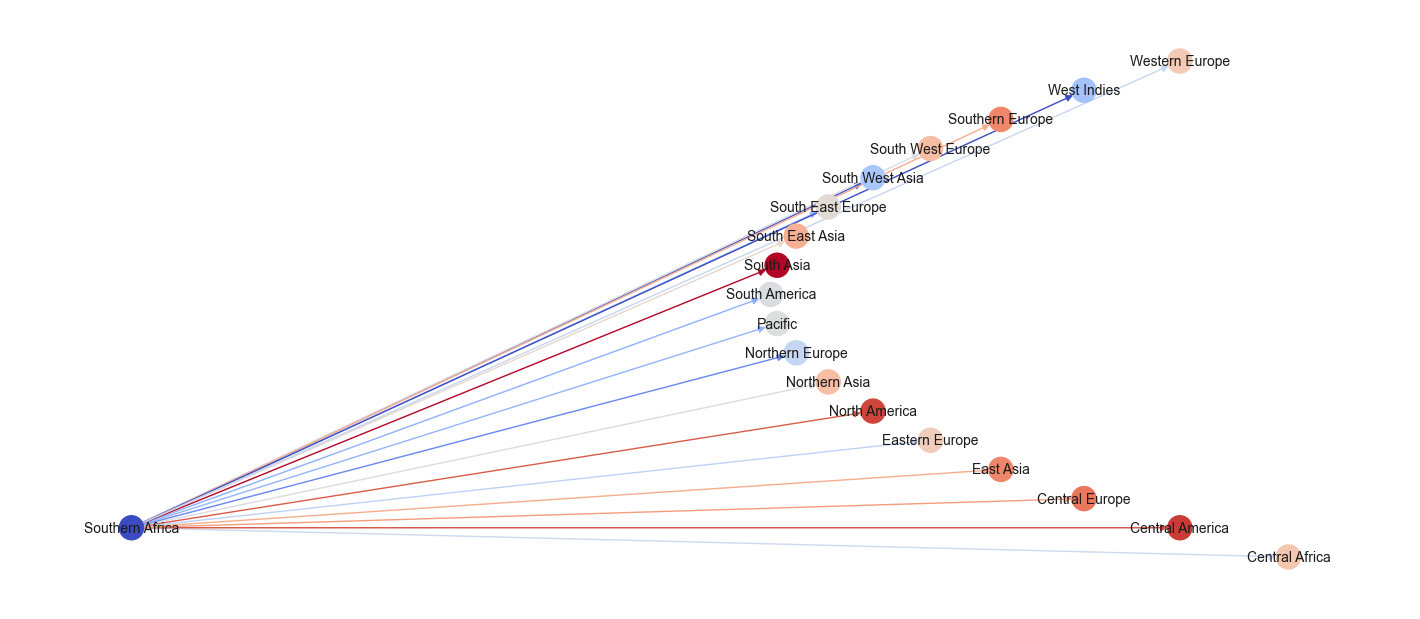

In [205]:
topological_order = list(nx.topological_sort(G_update))

in_degree_zero = [node for node, degree in G_update.in_degree() if degree == 0]    
pos = {}

for i, node in enumerate(in_degree_zero):
    pos[node] = (0, 2 * i)

remaining_nodes = [node for node in topological_order if node not in in_degree_zero]
for i, node in enumerate(remaining_nodes):
    pos[node] = (1 + 0.01 * (abs(len(remaining_nodes) // 2 - i)) ** 2, -len(in_degree_zero) // 2 + 1 * i)


node_colors = [G_update.nodes[node]['mean_error'] for node in G_update.nodes]

plt.figure(figsize=(14, 6))
nx.draw(
    G_update, 
    pos,
    with_labels=True, 
    arrows=True, 
    node_size=300, 
    font_size=10,
    arrowsize=10,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    edge_color=[d['difference'] for (_, _, d) in G_update.edges(data=True)],
    edge_cmap=plt.cm.coolwarm,
)
plt.show()

## Do users prefer beers from their region ?

In [207]:
ALPHA = 0.05
USERS_PER_REGION_THRESHOLD = 100
USERS_RATINGS_ON_REGION_THRESHOLD = 100
USERS_RATINGS_DIFFERENCE_THRESHOLD = 0.5

for user_region in df_rb_ratings['user_country_region'].unique():
    group = df_rb_ratings[df_rb_ratings['user_country_region'] == user_region]
    if len(group) < USERS_PER_REGION_THRESHOLD: continue

    for brewery_region in group['brewery_country_region'].unique():
        sub_group = group[group['brewery_country_region'] == brewery_region]
        if len(sub_group) < USERS_RATINGS_ON_REGION_THRESHOLD: continue

        result = stats.ttest_ind(group['rating_corrected'].dropna(), sub_group['rating_corrected'].dropna(), equal_var=False)
        difference = sub_group['rating_corrected'].mean() - group['rating_corrected'].mean()

        if result.pvalue < ALPHA and abs(difference) > USERS_RATINGS_DIFFERENCE_THRESHOLD: 
            print(f"[{user_region:.24s}] -> [{brewery_region:.24s}] {difference:.4f}")

[Western Europe] -> [South West Asia] -0.6199
[Western Europe] -> [Central America] -0.7893
[Western Europe] -> [South Asia] -0.9896
[Western Europe] -> [Southern Africa] -0.6075
[Western Europe] -> [Western Africa] -1.0197
[Western Europe] -> [Eastern Africa] -0.9350
[Western Europe] -> [South East Asia] -0.8437
[Western Europe] -> [Indian Ocean] -0.9101
[Western Europe] -> [West Indies] -0.9747
[Western Europe] -> [Northern Africa] -1.0214
[North America] -> [Eastern Europe] -0.5776
[North America] -> [East Asia] -0.5164
[North America] -> [Central America] -1.1015
[North America] -> [South East Europe] -0.8891
[North America] -> [South East Asia] -1.0480
[North America] -> [Northern Asia] -0.6990
[North America] -> [South West Asia] -0.8597
[North America] -> [Western Africa] -1.3926
[North America] -> [Southern Africa] -0.7455
[North America] -> [South America] -0.6138
[North America] -> [West Indies] -0.9275
[North America] -> [South Asia] -1.1691
[North America] -> [Eastern Afric

<Axes: xlabel='beer_global_style', ylabel='brewery_country_region'>

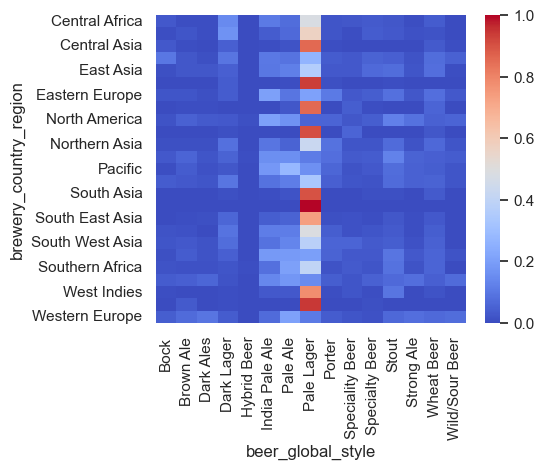

In [208]:
df_rb_production = df_rb_ratings.groupby(['brewery_country_region', 'beer_global_style']).size().reset_index().pivot(index='brewery_country_region', columns='beer_global_style', values=0).fillna(0)
df_rb_production = df_rb_production.div(df_rb_production.sum(axis=1), axis=0)

plt.figure(figsize=(5, 4))
sns.heatmap(df_rb_production, cmap='coolwarm')

<Axes: xlabel='beer_global_style', ylabel='user_country_region'>

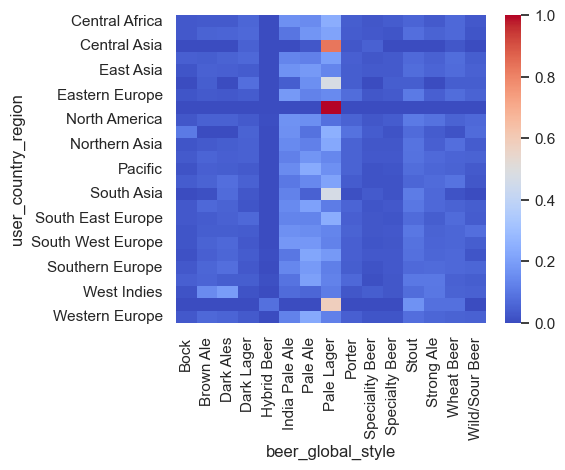

In [209]:
df_rb_ratings_region = df_rb_ratings.groupby(['user_country_region', 'beer_global_style']).size().reset_index().pivot(index='user_country_region', columns='beer_global_style', values=0).fillna(0)
df_rb_ratings_region = df_rb_ratings_region.div(df_rb_ratings_region.sum(axis=1), axis=0)

plt.figure(figsize=(5, 4))
sns.heatmap(df_rb_ratings_region, cmap='coolwarm')

**Since Pale lager are rated worst than other styles, maybe look at some effect like : North America dislike other beers because they account for a lot of rater and let's say South America produce Dark Lager which are dislike by North America**

## Beer style

In [211]:
NLP_MIN_RATINGS_PER_STYLE = 100

df_rb_nlp_style = df_rb_ratings.dropna(subset=['beer_global_style'])

ratings_per_style = df_rb_nlp_style['beer_global_style'].value_counts()
ratings_per_style = ratings_per_style[ratings_per_style >= NLP_MIN_RATINGS_PER_STYLE]
df_rb_nlp_style = df_rb_nlp_style[df_rb_nlp_style['beer_global_style'].isin(ratings_per_style.index)]

In [212]:
NLP_ERROR_COLUMN = 'rating_relative_error'
anova_result = f_oneway(*[group[NLP_ERROR_COLUMN].values for _, group in df_rb_nlp_style.groupby('beer_global_style')])
print(anova_result)

F_onewayResult(statistic=26499.64208907713, pvalue=0.0)


In [213]:
df_tukey_style = tukey_test(df_rb_nlp_style, 'beer_global_style', NLP_ERROR_COLUMN)

In [214]:
G = nx.DiGraph()

for i, row in df_tukey_style.iterrows():
    if row['absolute_difference'] < 0.01: continue

    G.add_node(row['group1'], mean_error=df_rb_nlp_regions[df_rb_nlp_regions['user_country_region'] == row['group1']][NLP_ERROR_COLUMN].mean())
    G.add_node(row['group2'], mean_error=df_rb_nlp_regions[df_rb_nlp_regions['user_country_region'] == row['group2']][NLP_ERROR_COLUMN].mean())

    if row['difference'] < 0:
        G.add_edge(row['group2'], row['group1'], weight=row['absolute_difference'], difference=row['absolute_difference'])
    else:
        G.add_edge(row['group1'], row['group2'], weight=row['absolute_difference'], difference=row['absolute_difference'])

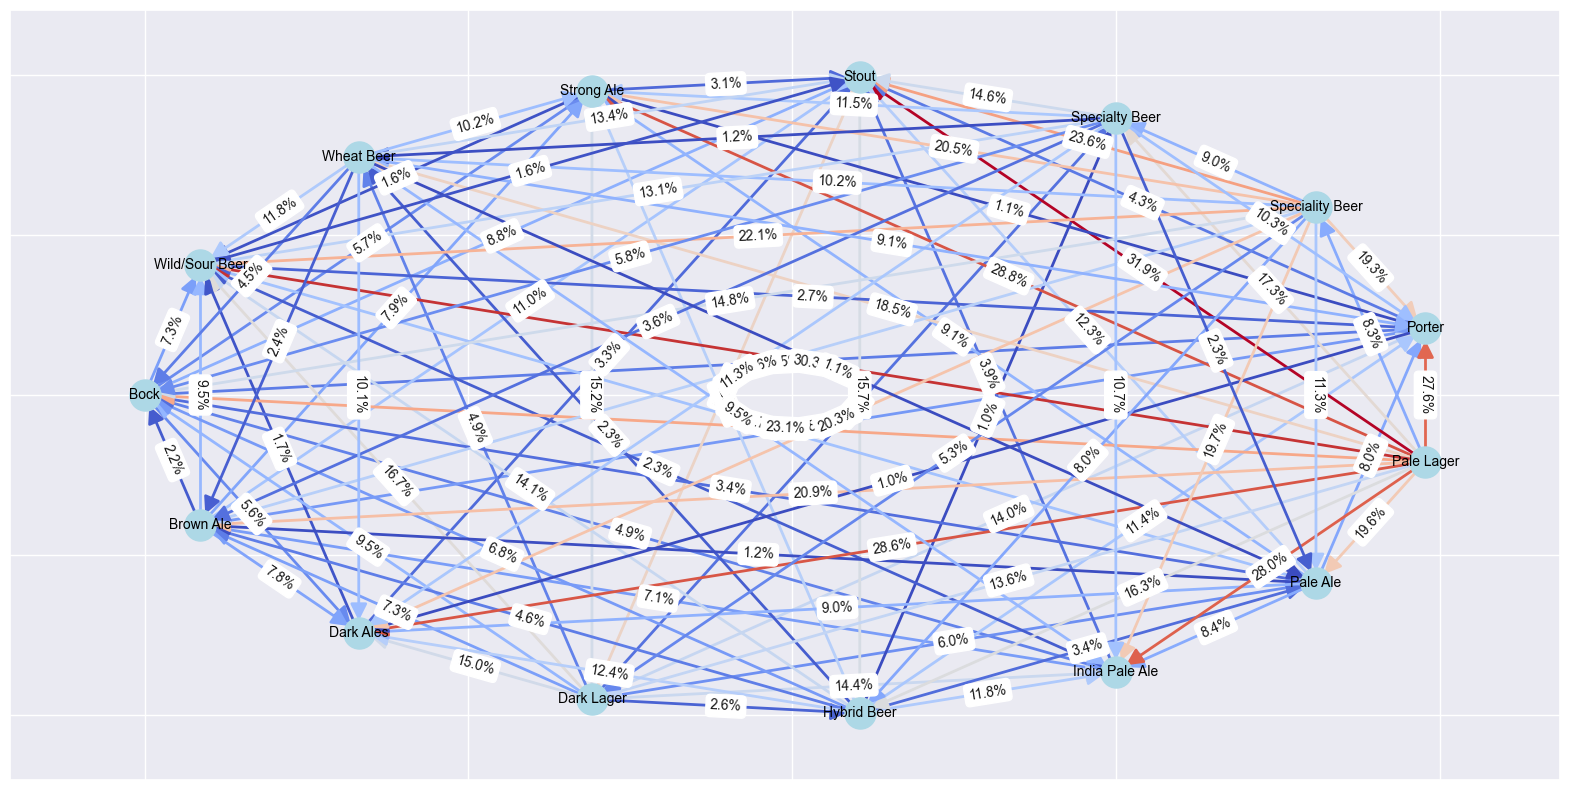

In [215]:
plt.figure(figsize=(20, 10))
pos = nx.shell_layout(G)

edges = G.edges(data=True)
edge_colors = [d['difference'] for (_, _, d) in edges]
edge_widths = [2 for (_, _, d) in edges]

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.coolwarm, arrowsize=25)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', )
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['difference']*100:.1f}%" for (u, v, d) in edges})

plt.show()

## Text analysis

In [219]:
from langdetect import detect
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurdhonneur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/arthurdhonneur/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arthurdhonneur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [220]:
df_rb_ratings.columns

Index(['user_id', 'beer_id', 'brewery_id', 'date', 'rating', 'overall',
       'aroma', 'appearance', 'palate', 'taste', 'text',
       'user_past_ratings_count', 'user_past_ratings_average',
       'beer_past_ratings_count', 'beer_past_ratings_average',
       'beer_global_style', 'user_beer_style_past_ratings_count',
       'user_beer_style_past_ratings_average', 'gini_impurity', 'day', 'week',
       'month', 'quarter', 'year', 'rating_corrected', '1', '2', '3', '4', '5',
       'nlp_weighted_rating', 'user_ratings_count', 'user_name',
       'user_created_date', 'user_country', 'user_region', 'user_country_code',
       'user_country_region', 'brewery_name', 'brewery_beers_count',
       'brewery_country', 'brewery_region', 'brewery_country_code',
       'brewery_country_region', 'rating_relative_error',
       'rating_absolute_error'],
      dtype='object')

In [221]:
stop_words = stop_words.union({
    'beer', 'overall', 'palate', 'aroma', 'taste', 'appearance'
})

In [222]:
def preprocess_text(text: str) -> list[str]:
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return words

In [223]:
def is_english(text: str) -> bool:
    try: return detect(text) == 'en'
    except: return False

In [224]:
df_rb_texts = df_rb_nlp_regions.dropna(subset=['text'])

df_rb_texts['is_english'] = df_rb_texts['text'].apply(is_english)
df_rb_texts = df_rb_texts[df_rb_texts['is_english']]

In [ ]:
df_rb_texts['text_preprocessed'] = df_rb_texts['text'].apply(preprocess_text)
df_rb_texts['text_preprocessed'] = df_rb_texts['text_preprocessed'].apply(lambda x: ' '.join(x))

In [ ]:
MIN_REVIEWS_PER_REGION = 100
reviews_per_region_counts = df_rb_texts.groupby('user_country_region').size()
reviews_per_region_counts = reviews_per_region_counts[reviews_per_region_counts > MIN_REVIEWS_PER_REGION]
df_rb_texts = df_rb_texts[df_rb_texts['user_country_region'].isin(reviews_per_region_counts.index)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_rb_documents = df_rb_texts.groupby('user_country_region')['text_preprocessed'].apply(lambda x: ' '.join(x)).reset_index()

vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_rb_documents['text_preprocessed'])
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=df_rb_documents['user_country_region'], columns=vectorizer.get_feature_names_out())

In [ ]:
top_words_df = pd.DataFrame(index=df_tfidf.index)
for index, row in df_tfidf.iterrows():
    top_words = row.sort_values(ascending=False).head(20).index.tolist()
    top_words_df.loc[index, [f'top_word_{i+1}' for i in range(20)]] = top_words
top_words_df

,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5,top_word_6,top_word_7,top_word_8,top_word_9,top_word_10,top_word_11,top_word_12,top_word_13,top_word_14,top_word_15,top_word_16,top_word_17,top_word_18,top_word_19,top_word_20
user_country_region,,,,,,,,,,,,,,,,,,,,
Central America,head,malt,hop,flavor,good,little,light,nice,sweet,dark,like,white,body,one,well,color,carbonation,great,alcohol,bit
Central Europe,sweet,malt,medium,good,note,hop,head,bottle,light,body,color,bit,strong,carbonation,caramel,lacing,pours,upfront,bubbled,yeast
East Asia,head,good,hop,light,one,like,malt,nice,bottle,sweet,bit,poured,flavor,dark,smell,little,carbonation,body,medium,color
Eastern Europe,malt,head,nice,nose,bit,like,sweet,quality,hop,bitter,one,light,good,note,mild,fruit,finish,quite,great,pour
North America,head,hop,malt,flavor,nice,light,good,like,sweet,bit,one,dark,carbonation,little,finish,smell,color,bottle,well,body
Northern Asia,head,body,carbonation,dark,good,poured,medium,hop,caramel,foam,sweet,smell,retentionsmell,white,nice,malt,bottle,soft,brown,low
Northern Europe,head,note,sweet,smell,malt,bitter,bit,hop,carbonation,nice,bitterness,fruit,medium,hint,lot,dark,liquid,aftertaste,light,good
Pacific,head,hop,malt,nice,flavour,light,good,bit,like,colour,sweet,quite,character,little,carbonation,body,pours,well,note,really
South America,nice,color,good,smell,head,malt,carbonation,great,dark,poured,sweet,light,note,one,body,alcohol,feel,like,hop,bitterness


# Preference

In [ ]:
df_rb_ratings['dominant_style'] = df_rb_ratings.groupby('user_id')['beer_global_style'].transform(lambda x: x.mode()[0])

In [ ]:
relationships = []
for group_style in df_rb_ratings['beer_global_style'].unique():
    group = df_rb_ratings[df_rb_ratings['dominant_style'] == group_style]
    group_users = group['user_id'].unique()
    group_mean  = group['rating_corrected'].mean()

    for target_style in df_rb_ratings['beer_global_style'].unique():
        style_ratings = df_rb_ratings[
            (df_rb_ratings['user_id'].isin(group_users)) &
            (df_rb_ratings['beer_global_style'] == target_style)
        ]['rating_corrected'] - group_mean
        
        if not style_ratings.empty:
            relationships.append({
                'group_style': group_style,
                'target_style': target_style,
                'mean_rating': style_ratings.mean(),
                'std_rating': style_ratings.std(),
                'num_ratings': style_ratings.count()
            })
df_rb_relationships = pd.DataFrame(relationships)

In [ ]:
G = nx.DiGraph()

for _, row in df_rb_relationships.iterrows():
    if row['num_ratings'] > 200 and abs(row['mean_rating']) > 0.2:
        G.add_edge(
            row['group_style'], 
            row['target_style'], 
            weight=row['num_ratings'], 
            rating=row['mean_rating']
        )

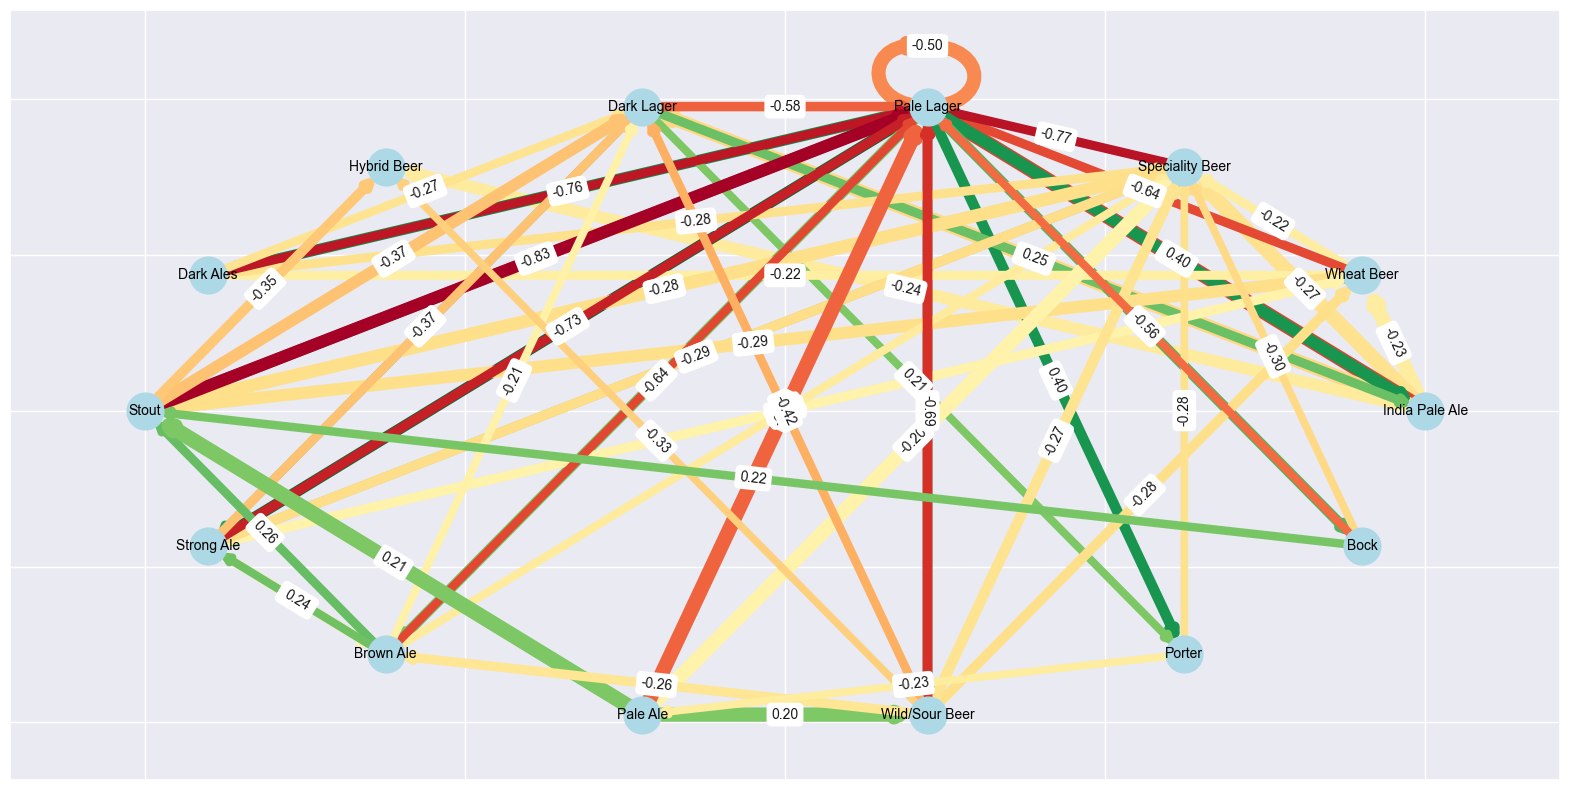

In [ ]:
pos = nx.circular_layout(G)
plt.figure(figsize=(20, 10))

nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

edges = G.edges(data=True)
edge_colors = [d['rating'] for (_, _, d) in edges]
edge_widths = [np.log(d['weight']) for (_, _, d) in edges]  # Scale thickness

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.RdYlGn)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['rating']:.2f}" for (u, v, d) in edges})

plt.show()